## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from prophet import Prophet
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Flatten, Dropout, MaxPooling1D, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

np.random.seed(42)
tf.random.set_seed(42)

## Load Data

In [2]:
cases_df = pd.read_csv('covid19_daily_data.csv')

# Convert date column to datetime
cases_df["Date_reported"] = pd.to_datetime(cases_df["Date_reported"])

# Aggregate New Cases for Global Infection Rate
daily_cases = cases_df.groupby("Date_reported")["New_cases"].sum().reset_index()

# Replace all -1 values with 0
daily_cases['New_cases'] = daily_cases['New_cases'].replace(-1, 0)

print('Sample size:', len(daily_cases))

Sample size: 1843


## Linear Regression on Covid-19 Data

Train Data size: 1474
Test Data size: 369
Linear Regression MAE: 549190.3607442562, MSE: 301995101737.4149


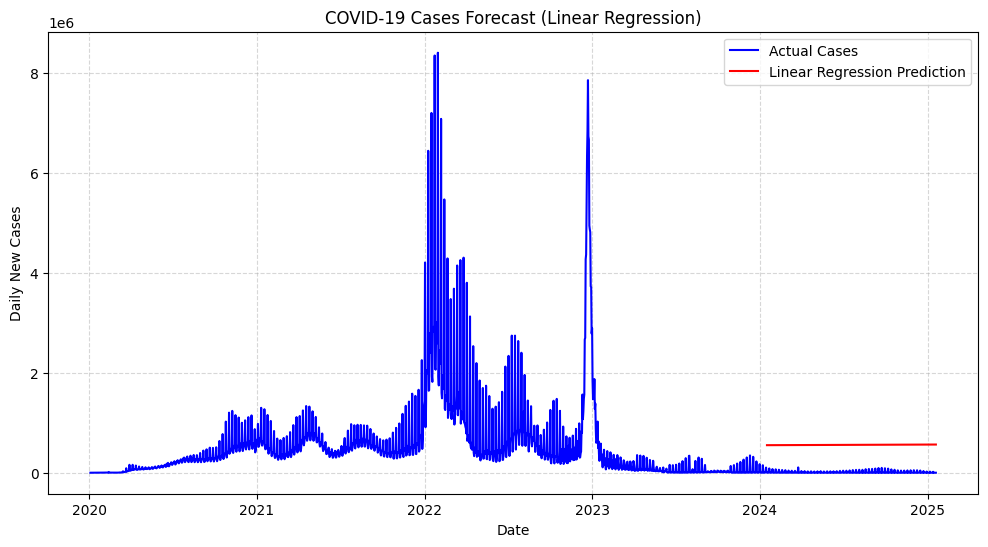

In [3]:
# Prepare Data for Time Series Forecasting
daily_cases["Days"] = (daily_cases["Date_reported"] - daily_cases["Date_reported"].min()).dt.days
X = daily_cases["Days"].values.reshape(-1, 1)
y = daily_cases["New_cases"].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
print('Train Data size:', len(X_train))
print('Test Data size:', len(X_test))

# Train a Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict future values using Linear Regression
y_pred_lr = lin_reg.predict(X_test)

# Evaluate Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr}, MSE: {mse_lr}")

# Plot Linear Regression Forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_cases["Date_reported"], daily_cases["New_cases"], label="Actual Cases", color="blue")
plt.plot(daily_cases["Date_reported"].iloc[len(X_train):], y_pred_lr, label="Linear Regression Prediction", color="red")
plt.title("COVID-19 Cases Forecast (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Daily New Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Findings from Linear Regression Forecasting

#### 1. Linear Regression Fails to Capture Trends
- The model predicts a **flat trend** for future COVID-19 cases, failing to capture the **wave-like pattern** seen in historical data.
- It does not account for **infection spikes** like vaccination and policy changes.

#### 2. High Prediction Error
- **MAE:** 549,190 | **MSE:** 30,199,510,378.40
- These values indicate that the model is **highly inaccurate**, suggesting large deviations from the actual case counts.

#### 3. Why Did It Fail?
- **Linear Regression assumes a straight-line trend**, while COVID-19 cases fluctuate with distinct **waves**.
- **Cannot model sudden spikes** (e.g., **Delta, Omicron waves**).

## Data Preprocessing

In [4]:
# Function to create sequences for LSTM
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

In [5]:
lookback = 10

# Split data into Training and Test Sets
train_size = int(len(daily_cases) * 0.8)

train_data = daily_cases['New_cases'][:train_size].values.reshape(-1, 1)
test_data = daily_cases['New_cases'][train_size:].values.reshape(-1, 1)

# Apply the MinMaxScaler on train and test
scaler = MinMaxScaler(feature_range=(0, 1))  
scaler.fit(train_data)  # Fit only on training data

scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Prepare Train & Validation Data
X, y = create_sequences(scaled_train_data, lookback)
val_size = int(len(X) * 0.8)

X_train, y_train = X[:val_size], y[:val_size]
X_val, y_val = X[val_size:], y[val_size:]

# Prepare Test Data
X_test, y_test = create_sequences(scaled_test_data, lookback)

# Inverse Transform
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

## LSTM on Covid-19 Data

In [28]:
# Create LSTM Model
model_lstm = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(100, activation='relu', return_sequences = True),
    LSTM(100, activation='relu'),
    Dense(25, activation='relu'),
    #Dropout(0.3),
    Dense(1)
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_lstm.compile(optimizer = optimizer, loss = 'mse')

# Train the model
history_lstm = model_lstm.fit(
    X_train, y_train, 
    epochs = 100, batch_size = 16, 
    validation_data=(X_val, y_val), 
    verbose=0
)

# Predict and Inverse Transform 
y_pred_val_lstm = model_lstm.predict(X_val)
y_pred_test_lstm = model_lstm.predict(X_test)

y_pred_val_lstm_inv = scaler.inverse_transform(y_pred_val_lstm)
y_pred_test_lstm_inv = scaler.inverse_transform(y_pred_test_lstm)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


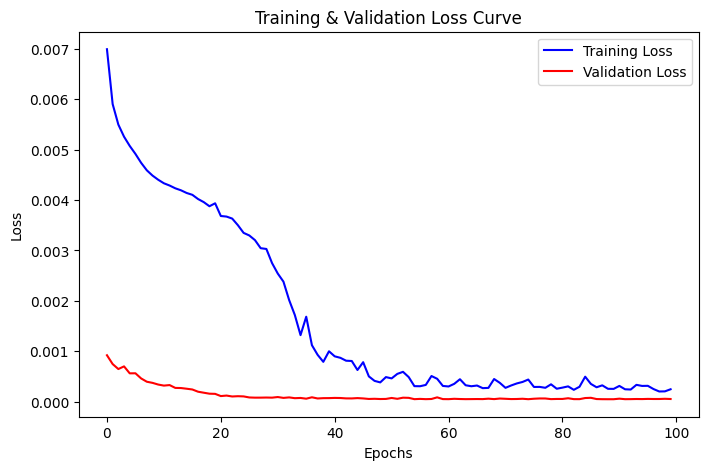

In [29]:
# Training and Validation Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history['loss'], label='Training Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.show()

#### Training vs. Validation Loss Analysis

##### The training loss consistently decreases, showing that the model is learning well.
##### The validation loss remains stable with a minimal gap, indicating no major overfitting but potential underfitting for long-term patterns.

In [30]:
# Adjust validation dates to match validation labels
val_dates = daily_cases["Date_reported"].iloc[1172:1172 + len(y_val_inv)].values

# Adjust test dates
test_dates = daily_cases["Date_reported"].iloc[1485:1485 + len(y_test_inv)].values

# Trim y-values to match dates
y_val_trimmed = y_val_inv[:len(val_dates)]
y_pred_val_trimmed = y_pred_val_lstm_inv[:len(val_dates)]

y_test_trimmed = y_test_inv[:len(test_dates)]
y_pred_test_trimmed = y_pred_test_lstm_inv[:len(test_dates)]

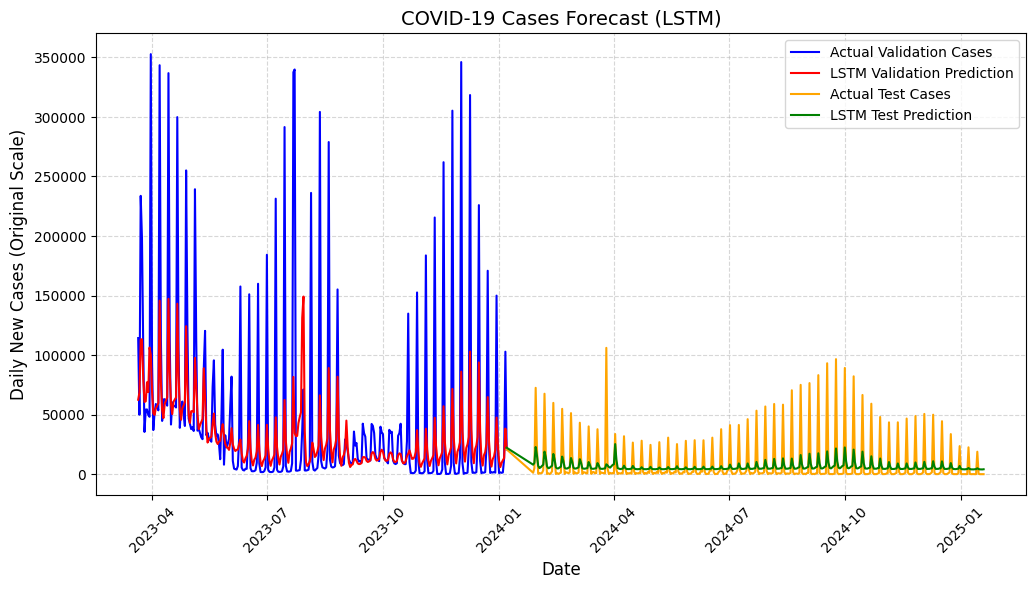

In [31]:
plt.figure(figsize=(12, 6))

# Plot Actual Validation Data
plt.plot(val_dates, y_val_trimmed, label="Actual Validation Cases", color="blue", linestyle="-")
plt.plot(val_dates, y_pred_val_trimmed, label="LSTM Validation Prediction", color="red", linestyle="-")

test_dates_aligned = [val_dates[-1]] + list(test_dates)  
y_test_trimmed_aligned = np.insert(y_test_trimmed, 0, y_val_trimmed[-1])  
y_pred_test_trimmed_aligned = np.insert(y_pred_test_trimmed, 0, y_pred_val_trimmed[-1])  

# Plot Test Data
plt.plot(test_dates_aligned, y_test_trimmed_aligned, label="Actual Test Cases", color="orange", linestyle="-")
plt.plot(test_dates_aligned, y_pred_test_trimmed_aligned, label="LSTM Test Prediction", color="green", linestyle="-")

# Formatting
plt.title("COVID-19 Cases Forecast (LSTM)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily New Cases (Original Scale)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

plt.show()

#### **Conclusions from the LSTM Forecasting**

##### LSTM Captures the Short-term trends well but struggles with extreme peaks 
- The LSTM validation predictions (red) closely follow the actual validation cases (blue), indicating that the model has **learned short-term patterns and local trend well**, it fails to capture extreme peaks or sudden declines, long-term shifts.
- The model is well-regularized but may lack sufficient capacity to generalize better.  
---
#### **Areas for Improvement**  
 
- **Feature Engineering:** Incorporate external features such as vaccination rates, mobility data, and seasonal effects.   
- **Hyper parameter Tuning:** Adjust LSTM units, batch size, drop out and learning rate through grid search or Bayesian optimization.
- **Hybrid approach** to capture both short-term and long-term trends.  

## Prophet Model on Covid-19 Data

19:48:19 - cmdstanpy - INFO - Chain [1] start processing
19:48:19 - cmdstanpy - INFO - Chain [1] done processing


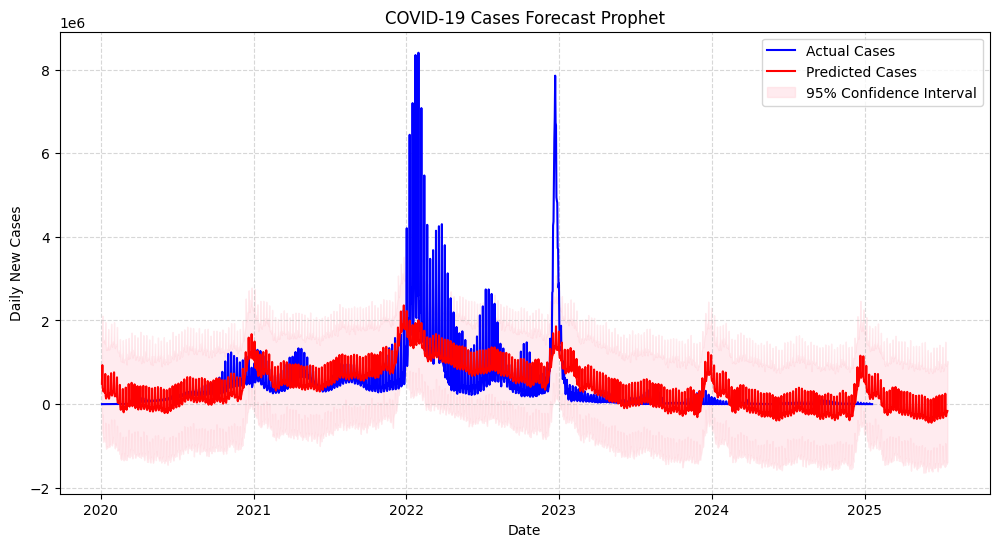

In [10]:
# Prepare Data for Prophet Model
prophet_df = daily_cases.rename(columns={"Date_reported": "ds", "New_cases": "y"})  # Prophet requires "ds" & "y" columns

# Train Prophet Model
model = Prophet(interval_width=0.95)  # 95% confidence interval
model.fit(prophet_df)

# Create Future Dates for Forecasting (Next 180 Days)
future_dates = model.make_future_dataframe(periods=180)

# Predict Future Cases
forecast = model.predict(future_dates)

# Plot Actual vs Predicted Infections
plt.figure(figsize=(12, 6))
plt.plot(prophet_df["ds"], prophet_df["y"], label="Actual Cases", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted Cases", color="red")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color='pink', alpha=0.3, label="95% Confidence Interval")
plt.title("COVID-19 Cases Forecast Prophet")
plt.xlabel("Date")
plt.ylabel("Daily New Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### **Conclusions on Facebook Prophet Forecasting**

##### **Prophet Captures Seasonality but Struggles with Sudden Surges**
- The red predicted cases follow a smoothed version of the actual cases (blue), indicating that Prophet effectively captures **seasonal trends**.
- However, it **fails to accurately predict extreme spikes** as the model relies on past seasonality but cannot foresee unexpected outbreaks.

---

##### **Areas of Improvement**
- **Feature Engineering:** Introduce external regressors like vaccination rates, policy measures, or mobility trends to improve forecast accuracy.
- **Hybrid Models:** Combine Prophet with other models like **LSTM or ARIMA** to improve short-term spike predictions while leveraging Prophet’s strength in capturing long-term seasonality.

## Hybrid CNN-LSTM on Covid-19 Data

In [11]:
# Create CNN-LSTM Model
model_cnn_lstm = Sequential([
    Input(shape=(lookback, 1)),
    Conv1D(filters = 4, kernel_size = 2, activation = 'relu'),
    LSTM(100, activation='relu', return_sequences=True),
    LSTM(100, activation='relu'),
    Dense(10),
    #Dropout(0.2),
    Dense(1)
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_cnn_lstm.compile(optimizer = optimizer, loss = tf.keras.losses.MeanSquaredError(), metrics = ['mae'])

# Train the model
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    epochs = 100, batch_size = 16,
    validation_data = (X_val, y_val),
    verbose = 0
)

# Predict on Validation and Test Sets
y_pred_val_cnn_lstm = model_cnn_lstm.predict(X_val)
y_pred_test_cnn_lstm = model_cnn_lstm.predict(X_test)

y_pred_val_cnn_lstm_inv = scaler.inverse_transform(y_pred_val_cnn_lstm)
y_pred_test_cnn_lstm_inv = scaler.inverse_transform(y_pred_test_cnn_lstm)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


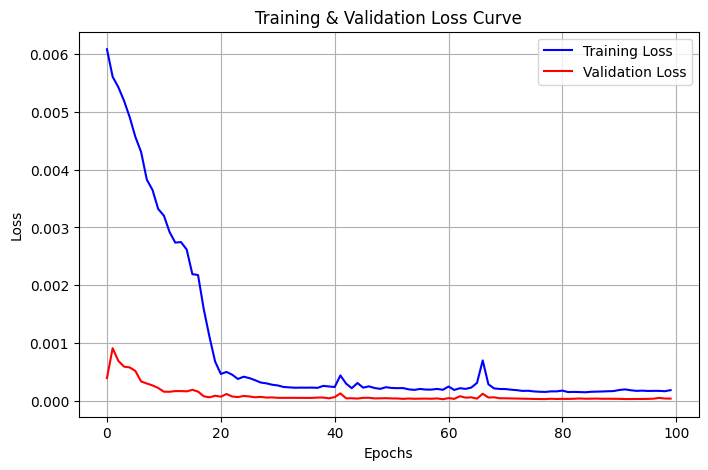

In [12]:
# Training and Validation Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss', color='blue')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Adjust validation dates to match validation labels
val_dates = daily_cases["Date_reported"].iloc[1172:1172 + len(y_val_inv)].values

# Adjust test dates
test_dates = daily_cases["Date_reported"].iloc[1485:1485 + len(y_test_inv)].values

# Trim y-values to match dates
y_val_trimmed = y_val_inv[:len(val_dates)]
y_pred_val_trimmed = y_pred_val_cnn_lstm_inv[:len(val_dates)]

y_test_trimmed = y_test_inv[:len(test_dates)]
y_pred_test_trimmed = y_pred_test_cnn_lstm_inv[:len(test_dates)]

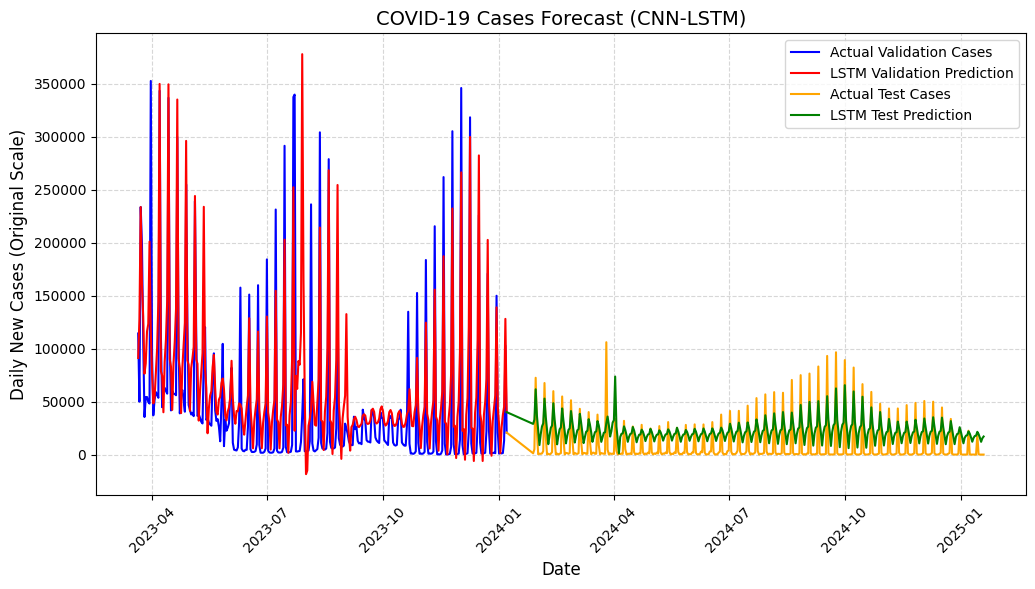

In [14]:
plt.figure(figsize=(12, 6))

# Plot Actual Validation Data
plt.plot(val_dates, y_val_trimmed, label="Actual Validation Cases", color="blue", linestyle="-")
plt.plot(val_dates, y_pred_val_trimmed, label="LSTM Validation Prediction", color="red", linestyle="-")

test_dates_aligned = [val_dates[-1]] + list(test_dates)  
y_test_trimmed_aligned = np.insert(y_test_trimmed, 0, y_val_trimmed[-1])  
y_pred_test_trimmed_aligned = np.insert(y_pred_test_trimmed, 0, y_pred_val_trimmed[-1])  

# Plot Test Data
plt.plot(test_dates_aligned, y_test_trimmed_aligned, label="Actual Test Cases", color="orange", linestyle="-")
plt.plot(test_dates_aligned, y_pred_test_trimmed_aligned, label="LSTM Test Prediction", color="green", linestyle="-")

# Formatting
plt.title("COVID-19 Cases Forecast (CNN-LSTM)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily New Cases (Original Scale)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

plt.show()

#### **Conclusions on CNN-LSTM Model Performance**

##### **CNN-LSTM Captures the Overall Trend but Struggles with Extreme Peaks**
- CNN-LSTM outperforms LSTM and Prophet in capturing peaks more effectively.
- However, CNN-LSTM still smooths out extreme variations, indicating a potential need for further tuning 
---

#### **Areas for Improvement**
- **Hyperparameter Tuning:** Adjusting kernel sizes, or using attention mechanisms).
- **Feature Engineering:** Incorporate external features such as **vaccination rates, mobility data, and government restrictions** to help the model adjust for real-world fluctuations.  
- **Hybrid Models:** Experiment with hybrid models **CNN-LSTM + Transformer** approach might enhance peak detection even further.

# Conclusions and future scope
#### **Final Takeaways**
- **For short-term forecasting →** LSTM performs well.
- **For long-term trend estimation →** Prophet is useful.
- **For peak detection and adaptive forecasting →** CNN-LSTM is superior but can be further improved with attention mechanisms.

---

#### **Future Scope & Enhancements**

##### **1. Hybrid Models for Peak Detection**
- Combine **CNN-LSTM with Transformers** to enhance long-term dependency learning.  
- Explore **Attention Mechanisms**to focus on critical peaks and fluctuations.

##### **2. Feature Engineering & External Data Integration**
- Incorporate **vaccination rates, government restrictions, and mobility data** to improve peak predictions.  
- Use **Fourier Transforms or Wavelet Transforms** for better frequency-domain feature extraction.

##### **3. Model Optimization & Hyperparameter Tuning**
- Use **Grid Search** to refine learning rates, dropout, and batch sizes. 
- Experiment with **Conv1D filter sizes** to capture multi-scale patterns.

##### **4. Alternative Time-Series Models**
- Test **Transformer-based models** (e.g., **Temporal Fusion Transformers, LongNet**) for adaptive forecasting.  
- Explore **Graph Neural Networks (GNNs)** to model **COVID spread across regions**.

# Predictions & Insights on Future COVID-19 Waves

#### Future waves with new variants may still cause periodic surges  
- The decreasing severity of **recent waves (2023 onward)** suggests that **COVID-19 is transitioning into an endemic disease**, similar to the **seasonal flu**.  
- The **Omicron wave** showed that **mutations can increase transmissibility while being less lethal**.  
- Future waves may still occur but are expected to be **less severe** likely to cause mild to moderate cases instead of severe outbreaks due to **herd immunity, vaccinations, and improved treatments**.
- Post-2022, **cases may still fluctuate**, but **deaths have remained stable** due to:
  - **Higher immunity levels** (natural + vaccine-induced).  
  - **Better medical interventions** (antivirals, monoclonal antibodies, etc.).  
  - **More awareness & preventive measures** (masking, testing, boosters).  
- This suggests that **future waves might not be as concerning** in terms of mortality, even if infections continue. 

#### Seasonality May Play a Role  
- COVID-19 may follow a **seasonal trend**, similar to influenza, with **spikes in colder months (winter)** when respiratory infections spread more.  
- Future waves may **coincide with flu season**, requiring **annual booster vaccinations** for high-risk populations.  

#### Vaccination & Boosters Will Remain Important  
- **Mass vaccination efforts (green = fully vaccinated, purple = one dose) helped control severe cases & deaths.**  
- **Regular booster shots for high-risk individuals** may continue to be a **key strategy** to prevent severe illness from new variants.   

#### **Conclusion**  
- **Future waves are possible**, but they will likely be **less severe & more predictable**.  
- **Vaccination, early detection, and treatments** will remain key factors in **minimizing impact**, requiring **seasonal management similar to the flu**.  
